# Libraries

In [1]:
import seaborn as sns; sns.set(color_codes=True)  # visualization tool
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statistics
import collections
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from datetime import datetime
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from IPython.display import display
from sklearn.ensemble import AdaBoostClassifier
import keras
from keras.models import Sequential , Model
from keras.layers import (
                          Dense,
                          Add,
                          Conv2D,
                          MaxPool2D,
                          Flatten,
                          Dropout,
                          MaxPooling2D,
                          Input,
                          Conv2DTranspose,
                          Concatenate,
                          BatchNormalization,
                          UpSampling2D,
                          AveragePooling2D,
                          GlobalAveragePooling2D,
                          Activation,
                          ZeroPadding2D
                      )
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam , SGD
from keras.layers import Concatenate
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import to_categorical # convert to one-hot-encoding
from sklearn.metrics import classification_report,confusion_matrix
from PIL import Image
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
import itertools
import shutil
from tensorflow.keras.models import Model, load_model
import imutils
from tensorflow.keras import optimizers
import cv2 as cv
import seaborn as sns
from random import choices
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.initializers import glorot_uniform
from keras.applications import ResNet50, VGG16, InceptionV3, Xception, MobileNet, DenseNet121

# Google Drive Mount

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
Patient_info_file_path = '/content/gdrive/MyDrive/Thesis/Patient_Info.csv'
patient_info = pd.read_csv(Patient_info_file_path)

# Adding "Tumor_label" column

In [4]:
patient_info["Tumor_label"]= patient_info["Tumor_Type"]
cleanup_nums = {
    "Tumor_label":{'Null':0  , "Benign":1 , 'Malignant':1 }
}
patient_info = patient_info.replace(cleanup_nums)
del cleanup_nums

In [5]:
patient_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Patient_Num              111 non-null    int64 
 1   Patient_ID               111 non-null    object
 2   Age                      111 non-null    int64 
 3   Gender                   111 non-null    object
 4   Test                     111 non-null    object
 5   Date                     111 non-null    int64 
 6   Taking_Contrast          111 non-null    object
 7   Clinical_data            111 non-null    object
 8   Symptoms                 111 non-null    object
 9   Diagnosing_test          111 non-null    object
 10  Diagnosing_Right_Kidney  111 non-null    object
 11  Injure_range_Right_K     111 non-null    object
 12  Segmentation_Right       111 non-null    object
 13  Diagnosing_Left_Kidney   111 non-null    object
 14  Injure_range_Left_K      111 non-null    o

In [6]:
patient_info.sample(5)

,Patient_Num,Patient_ID,Age,Gender,Test,Date,Taking_Contrast,Clinical_data,Symptoms,Diagnosing_test,...,Injure_range_Right_K,Segmentation_Right,Diagnosing_Left_Kidney,Injure_range_Left_K,Segmentation_Left,Stage,Situation,Tumor_Type,Tumor_Class,Tumor_label
99,100,KA00017541,52,Male,CT ABDOMEN PELVIS,2021,No,Not provided,Flank pain,Multipe stone,...,"Stone 0.4 cm, hydronephrosis 1 cm",Middle calyceal,Stone,Small stone,Undefined,Null,Normal case,Null,Null,0
105,106,KA00019402,46,Male,CT ABDOMEN PELVIS,2020,No,Not provided,Flank pain,"The right kidney appears bulky, fat stranding,...",...,"Bulky, fat",Undefined,Stone,Stone 2 mm,Midportion,Null,Normal case,Null,Null,0
97,98,KA00188941,48,Male,CT ABDOMEN PELVIS,2020,No,Not provided,Flank pain,"Stone in proximal right ureter 0.7 x 0.6 cm, d...",...,Hydroureteronephrosis 2.1 cm,Right renal pelvis,Healthy,Healthy,Undefined,Null,Normal case,Null,Null,0
62,63,KA00144722,36,Female,CT ABDOMEN PELVIS,2020,Yes,Liver cyst,Not provided,"Lesions liver, Right adnexal cyst is 4.5 x 4.2...",...,Healthy,Undefined,Cyst,Cyst 0.5 cm,Upper pole,Null,Normal case with cyst,Null,Null,0
61,62,KA00202545,55,Female,CT ABDOMEN PELVIS,2020,Yes,Umbilical hernia,Abdomen pain,Large uncomplicated umbilical hernia containin...,...,Cyst 1 x 0.8 cm,Midpole,Healthy,Healthy,Undefined,Null,Normal case with cyst,Null,Null,0


In [7]:
def crop_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

In [8]:
labels = {0:"Normal" , 1:"Tumor"}

def get_data(data_dir, target):
    X = list()
    y = list()
    img_size = 256

    for index, row in patient_info.iterrows():
        path = os.path.join(data_dir, str(row['Patient_Num']))

        # Add error handling to check if the directory exists
        if not os.path.exists(path):
            print(f"Directory not found: {path}")
            continue  # Skip to the next iteration

        label = row[target]

        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1]
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                X.append(resized_arr)
                y.append(label)
            except Exception as e:
                print(f"Error processing image: {e}, Patient_Num: {row['Patient_Num']}")

    return X, y


In [ ]:
X , y  = get_data("/content/gdrive/MyDrive/Thesis/PatientWiseImage", target = "Tumor_label")

In [ ]:
dict(zip(list(y),[list(y).count(i) for i in list(y)]))

{1: 4200, 0: 3570}

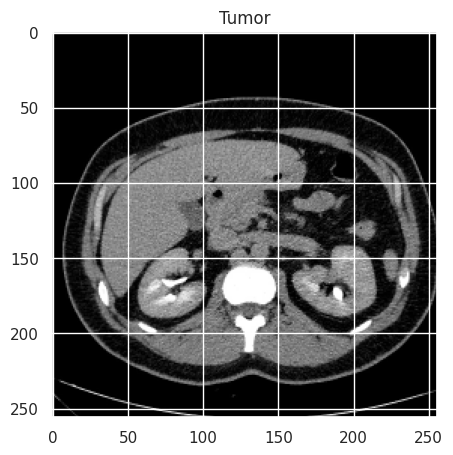

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(X[20])
plt.title(labels[y[20]])
plt.show()

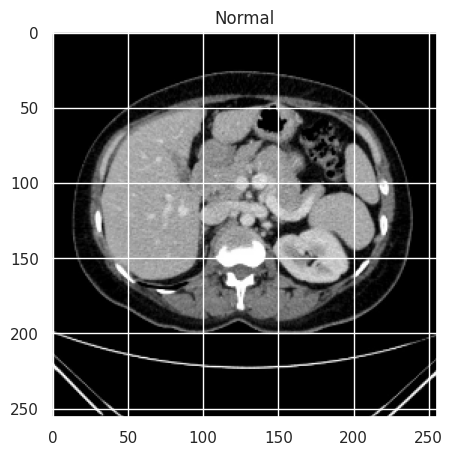

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(X[6000])
plt.title(labels[y[6000]])
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test , test_size = 0.10)

In [ ]:
print ("Number images for training : {}".format(len (x_train)) , dict(zip(list(y_train),[list(y_train).count(i) for i in list(y_train)])) )
print ("Number images for testing : {}".format(len (x_test)), dict(zip(list(y_test),[list(y_test).count(i) for i in list(y_test)])) )
print ("Number images for Validation : {}".format(len (x_val)) ,  dict(zip(list(y_val),[list(y_val).count(i) for i in list(y_val)])) )

Number images for training : 5439 {1: 2944, 0: 2495}
Number images for testing : 2097 {0: 980, 1: 1117}
Number images for Validation : 234 {1: 139, 0: 95}


In [ ]:
def data_prepare (X , y , folder_name , labels ) :
    path = "/content/gdrive/MyDrive/Thesis/{}".format(folder_name)
    os.mkdir(path)
    # create folder for labels
    for key , value in labels.items()  :
        path = "/content/gdrive/MyDrive/Thesis/{}/{}".format(folder_name,value)
        os.mkdir(path)

    if len (X) != len (y) :
      print ("error size data X and y is not equal")
      return

    for index , value in enumerate(y) :
      im = Image.fromarray(X[index])
      path = "/content/gdrive/MyDrive/Thesis/{}/{}/{}.jpeg".format(folder_name,labels[value],str(index))
      im.save(path)
    return


In [ ]:
data_prepare (X=x_train ,y=y_train ,folder_name="train", labels=labels )

In [ ]:
data_prepare (X=x_test ,y=y_test ,folder_name="test", labels=labels )

In [ ]:
data_prepare (X=x_val ,y=y_val ,folder_name="validation", labels=labels )

# Genrating Images

In [9]:
train_datagen = ImageDataGenerator(shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [10]:
test_datagen = ImageDataGenerator()

In [11]:

training_set = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Thesis/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')

Found 5439 images belonging to 2 classes.


In [12]:
test_set = test_datagen.flow_from_directory('/content/gdrive/MyDrive/Thesis/test',
                                            target_size = (224,224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 2097 images belonging to 2 classes.


In [13]:
validation_set = test_datagen.flow_from_directory('/content/gdrive/MyDrive/Thesis/validation',
                                            target_size = (224,224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 234 images belonging to 2 classes.


In [14]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Models

In [15]:
class AccuracyStopping(keras.callbacks.Callback):
    def __init__(self, acc_threshold):
        super(AccuracyStopping, self).__init__()
        self._acc_threshold = acc_threshold

    def on_epoch_end(self, batch, logs={}):
        train_acc = logs.get('accuracy')
        print(train_acc)
        value=1-train_acc
        print(value)
        self.model.stop_training = value <= self._acc_threshold

acc_callback = AccuracyStopping(0.02)

# CNN-6

In [ ]:
def get_Model():
    modelName= Sequential()
    modelName.add(BatchNormalization(input_shape = (224,224,3)))
    modelName.add(Conv2D(32, (3, 3), input_shape = (224, 224, 3), activation = 'relu'))
    modelName.add(MaxPooling2D(pool_size = (2, 2)))
    modelName.add(Dropout(0.25))
    modelName.add(Flatten())
    modelName.add(Dense(units = 128, activation = 'relu'))
    modelName.add(Dense(units = 2, activation = 'softmax'))
    return modelName

In [ ]:
x=get_Model()

In [ ]:
x.compile(
    optimizer='adam' ,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']    )

In [ ]:
history = x.fit(
          training_set,
          steps_per_epoch = (5439 /32),
          epochs=50,
          validation_data=validation_set,
          validation_steps = (234 /32)
                          )

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 3440s 20s/step - loss: 4.0589 - accuracy: 0.5940 - val_loss: 0.5984 - val_accuracy: 0.7051
Epoch 2/50
169/169 [==============================] - 86s 508ms/step - loss: 0.6353 - accuracy: 0.6635 - val_loss: 0.5297 - val_accuracy: 0.7393
Epoch 3/50
169/169 [==============================] - 85s 500ms/step - loss: 0.5959 - accuracy: 0.7009 - val_loss: 0.5616 - val_accuracy: 0.7179
Epoch 4/50
169/169 [==============================] - 84s 493ms/step - loss: 0.5586 - accuracy: 0.7194 - val_loss: 0.5270 - val_accuracy: 0.7350
Epoch 5/50
169/169 [==============================] - 86s 505ms/step - loss: 0.5285 - accuracy: 0.7391 - val_loss: 0.5111 - val_accuracy: 0.7521
Epoch 6/50
169/169 [==============================] - 86s 506ms/step - loss: 0.5069 - accuracy: 0.7621 - val_loss: 0.4508 - val_accuracy: 0.7821
Epoch 7/50
169/169 [==============================] - 86s 501ms/step - loss: 0.5049 - accuracy: 0.7509 - val_loss: 0.4580 - val_accuracy: 0.7

In [ ]:
import pickle

with open('training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:
# Load the saved history
with open('training_history.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

In [ ]:
# Access the training/validation loss and accuracy
print(loaded_history['loss'])
print(loaded_history['val_loss'])
print(loaded_history['accuracy'])
print(loaded_history['val_accuracy'])

[4.058949947357178, 0.6353112459182739, 0.5959064364433289, 0.5586303472518921, 0.5285285711288452, 0.5069462656974792, 0.5049461722373962, 0.46330341696739197, 0.4696277976036072, 0.4568447470664978, 0.431601881980896, 0.4052857458591461, 0.3562515676021576, 0.34318897128105164, 0.3172561228275299, 0.30018049478530884, 0.2952117323875427, 0.27349600195884705, 0.2507342994213104, 0.2380995750427246, 0.2192208170890808, 0.21490149199962616, 0.2006918042898178, 0.21777741611003876, 0.20706596970558167, 0.18654340505599976, 0.17185288667678833, 0.179087832570076, 0.17589493095874786, 0.17004473507404327, 0.13723061978816986, 0.13670127093791962, 0.14320188760757446, 0.14308714866638184, 0.1667097508907318, 0.1288648247718811, 0.1360204964876175, 0.13552738726139069, 0.11038259416818619, 0.11950311809778214, 0.11821252107620239, 0.11853896826505661, 0.11535815894603729, 0.11075388640165329, 0.11092214286327362, 0.10852953046560287, 0.10740245133638382, 0.09332679957151413, 0.09517535567283

In [ ]:
x.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 224, 224, 3)       12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 128)               5

In [ ]:
print('Training Set Clases : ', training_set.class_indices )
print("=="*10)
print('Testing Set Clases : ' , test_set.class_indices )

Training Set Clases :  {'Normal': 0, 'Tumor': 1}
Testing Set Clases :  {'Normal': 0, 'Tumor': 1}


In [ ]:
loss,accuracy=x.evaluate(test_set)
print (f"Test Loss     = {loss}")
print (f"Test Accuracy = {accuracy}")

66/66 [==============================] - 1527s 23s/step - loss: 0.1254 - accuracy: 0.9561
Test Loss     = 0.12542395293712616
Test Accuracy = 0.9561278223991394


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(15, 15))

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize = (15 ,15) , dpi=80,)
ax.set_facecolor('#ffffff')
ax.xaxis.label.set_color('#000000')
ax.yaxis.label.set_color('#000000')
ax.tick_params(axis='x', colors='#000000' )
ax.tick_params(axis='y', colors='#000000')
ax.spines['left'].set_color('#000000')
ax.spines['bottom'].set_color('#000000')

Text(0.5, 1.0, 'Training and Validation Accuracy')

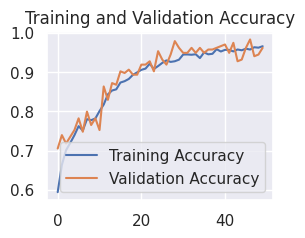

In [ ]:
plt.subplot(2, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


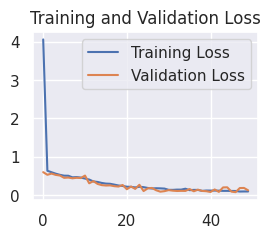

In [ ]:
plt.subplot(2, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.preprocessing import image
color=['#ff6600','#1976D2']

In [ ]:
path='/content/gdrive/MyDrive/Thesis/test/Normal'
l_Normal =[]

In [ ]:
filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Normal =[1]*len(filelist)
print ("Number of images for Normal :" , len (filelist))

Number of images for Normal : 930


In [ ]:
filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Normal =[0]*len(filelist)
print ("Number of images for Normal :" , len (filelist))

Number of images for Normal : 930


In [ ]:
for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Normal.append(test_image)

In [ ]:
l_Normal_result = []

for i in range(len(l_Normal)):
    # Assuming x is your Sequential model
    predictions = x.predict(l_Normal[i])

    # Extract the predicted classes (assuming one-hot encoded)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    l_Normal_result.append(predicted_classes)


1/1 [==============================] - 0s 17ms/step


In [ ]:
l_Normal_draw=[]
for i in range(len(l_Normal_result)):
    if (l_Normal_result[i][0] == 0):
        l_Normal_draw.append("Normal")
    else :
        l_Normal_draw.append("Tumor")

In [ ]:
display('==='*10)
display(dict(zip(list(l_Normal_draw),[list(l_Normal_draw).count(i) for i in list(l_Normal_draw)])))
display('==='*10)

'=============================='

{'Normal': 906, 'Tumor': 24}

'=============================='

In [ ]:
res = dict(zip(list(l_Normal_draw),[list(l_Normal_draw).count(i) for i in list(l_Normal_draw)]))
print(res)
labels = ['Normal','Tumor']

{'Normal': 906, 'Tumor': 24}


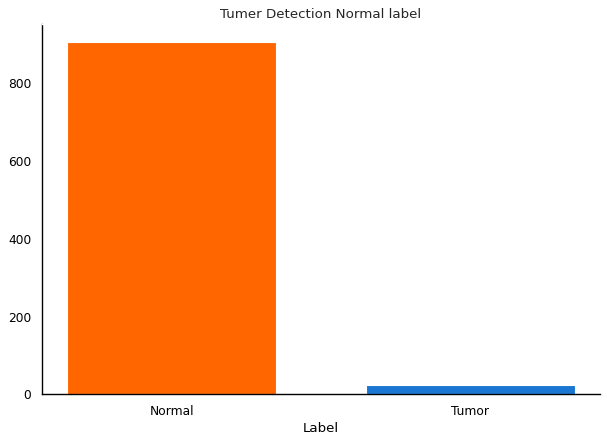

In [ ]:
fig, ax = plt.subplots(figsize = (9 , 6) , dpi=80,)
ax.set_facecolor('#ffffff')
ax.xaxis.label.set_color('#000000')
ax.yaxis.label.set_color('#000000')
ax.tick_params(axis='x', colors='#000000' )
ax.tick_params(axis='y', colors='#000000')
ax.spines['left'].set_color('#000000')        # setting up Y-axis tick color to red
ax.spines['bottom'].set_color('#000000')
plt.bar( labels , res.values() ,width = 0.7,  color=[ '#ff6600', '#1976D2'] ,  align='center' , zorder=1)
plt.xlabel('Label')
plt.title('Tumer Detection Normal label')
plt.show()

In [ ]:
print(res)

{'Normal': 906, 'Tumor': 24}


In [ ]:
print(set(res.values()))

{24, 906}


In [ ]:
path='/content/gdrive/MyDrive/Thesis/test/Tumor'
l_Tumor=[]

In [ ]:
filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Tumor =[1]*len(filelist)
print ("Number of images for Tumor :" , len (filelist))

Number of images for Tumor : 1167


In [ ]:
for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Tumor.append(test_image)

In [ ]:
l_Tumor_result=[]

for i in range(len(l_Tumor)):
    # Assuming x is your Sequential model
    predictions = x.predict(l_Tumor[i])

    # Extract the predicted classes (assuming one-hot encoded)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    l_Tumor_result.append(predicted_classes)

NameError: name 'l_Tumor' is not defined

In [ ]:
l_Tumor_draw=[]
for i in range(len(l_Tumor_result)):
    if (l_Tumor_result[i][0]== 0):
        l_Tumor_draw.append("Normal")
    else :
        l_Tumor_draw.append("Tumor")

In [ ]:
display('==='*10)
display(dict(zip(list(l_Tumor_draw),[list(l_Tumor_draw).count(i) for i in list(l_Tumor_draw)])))
display('==='*10)

'=============================='

{'Tumor': 121, 'Normal': 3}

'=============================='

In [ ]:
res2 = dict(zip(list(l_Tumor_draw),[list(l_Tumor_draw).count(i) for i in list(l_Tumor_draw)]))
print(res2)
labels = ['Normal','Tumor']

{'Tumor': 121, 'Normal': 3}


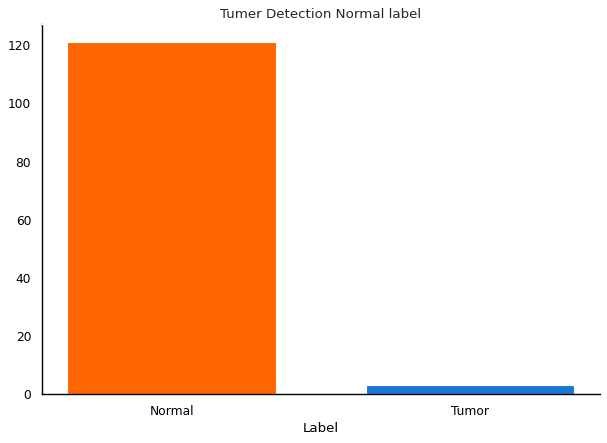

In [ ]:
fig, ax = plt.subplots(figsize = (9 , 6) , dpi=80,)
ax.set_facecolor('#ffffff')
ax.xaxis.label.set_color('#000000')
ax.yaxis.label.set_color('#000000')
ax.tick_params(axis='x', colors='#000000' )
ax.tick_params(axis='y', colors='#000000')
ax.spines['left'].set_color('#000000')        # setting up Y-axis tick color to red
ax.spines['bottom'].set_color('#000000')
plt.bar( labels , res2.values() ,width = 0.7,  color=[ '#ff6600', '#1976D2'] ,  align='center' , zorder=1)
plt.xlabel('Label')
plt.title('Tumer Detection Normal label')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [ ]:
print('Training Set Clases')
print(training_set.class_indices)
print('Testing Set Clases')
print(test_set.class_indices)
print("======"*10)
print('\nConfusion Matrix')
print('Classification Report')
target_names = ['Normal', 'Tumor']

Training Set Clases
{'Normal': 0, 'Tumor': 1}
Testing Set Clases
{'Normal': 0, 'Tumor': 1}

Confusion Matrix
Classification Report


In [ ]:
y_labels  = y_Normal +y_Tumor
x_results = l_Normal_result + l_Tumor_result
print(classification_report( y_labels , x_results , target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.97      0.92      0.94       110
       Tumor       0.93      0.98      0.95       124

    accuracy                           0.95       234
   macro avg       0.95      0.95      0.95       234
weighted avg       0.95      0.95      0.95       234



In [ ]:
# x.save('/content/gdrive/MyDrive/Thesis/Tumer_classification/best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


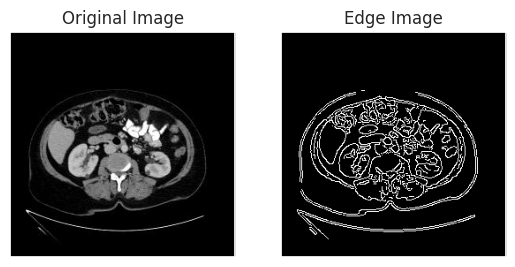

In [ ]:
path='/content/gdrive/MyDrive/Thesis/validation/Normal/90.jpeg'
path2='/content/gdrive/MyDrive/Thesis/validation/Tumor/110.jpeg'
img=cv2.imread(path)
edges = cv2.Canny(img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

# CNN-13

In [ ]:
def get_Model2():
    modelName1 = Sequential()
    modelName1.add(BatchNormalization(input_shape=(224, 224, 3)))
    modelName1.add(Conv2D(32, (3, 3), activation='relu'))
    modelName1.add(MaxPooling2D(pool_size=(2, 2)))
    modelName1.add(Conv2D(64, (3, 3), activation='relu'))
    modelName1.add(MaxPooling2D(pool_size=(2, 2)))
    modelName1.add(Conv2D(128, (3, 3), activation='relu'))
    modelName1.add(MaxPooling2D(pool_size=(2, 2)))
    modelName1.add(Dropout(0.25))
    modelName1.add(Flatten())
    modelName1.add(Dense(units=256, activation='relu'))
    modelName1.add(Dense(units=128, activation='relu'))
    modelName1.add(Dense(units=2, activation='softmax'))
    return modelName1

In [ ]:
x1=get_Model2()

In [ ]:
x1.compile(
    optimizer='adam' ,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']    )

In [ ]:
history = x1.fit(
          training_set,
          steps_per_epoch = (5439 /32),
          epochs=30,
          validation_data=validation_set,
          validation_steps = (234 /32)
                          )

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 753s 4s/step - loss: 0.7673 - accuracy: 0.5858 - val_loss: 0.6012 - val_accuracy: 0.6880
Epoch 2/30
169/169 [==============================] - 68s 398ms/step - loss: 0.5917 - accuracy: 0.6738 - val_loss: 0.4591 - val_accuracy: 0.7735
Epoch 3/30
169/169 [==============================] - 66s 388ms/step - loss: 0.4809 - accuracy: 0.7762 - val_loss: 0.3052 - val_accuracy: 0.8761
Epoch 4/30
169/169 [==============================] - 68s 398ms/step - loss: 0.3610 - accuracy: 0.8415 - val_loss: 0.1796 - val_accuracy: 0.9188
Epoch 5/30
169/169 [==============================] - 67s 392ms/step - loss: 0.2887 - accuracy: 0.8788 - val_loss: 0.1323 - val_accuracy: 0.9530
Epoch 6/30
169/169 [==============================] - 68s 399ms/step - loss: 0.2150 - accuracy: 0.9127 - val_loss: 0.1238 - val_accuracy: 0.9444
Epoch 7/30
169/169 [==============================] - 67s 395ms/step - loss: 0.1742 - accuracy: 0.9342 - val_loss: 0.1315 - val_accuracy: 0.948

In [ ]:

import pickle

with open('training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)


In [ ]:
# Load the saved history
with open('training_history.pkl', 'rb') as file:
    loaded_history = pickle.load(file)


In [ ]:
# Access the training/validation loss and accuracy
print(loaded_history['loss'])
print(loaded_history['val_loss'])
print(loaded_history['accuracy'])
print(loaded_history['val_accuracy'])

[0.7673086524009705, 0.5916571617126465, 0.48085105419158936, 0.36098453402519226, 0.2887379825115204, 0.2149740308523178, 0.17417268455028534, 0.14074906706809998, 0.12301257252693176, 0.11125151067972183, 0.08854406327009201, 0.06508022546768188, 0.07136815041303635, 0.07237520068883896, 0.06124046817421913, 0.051152464002370834, 0.054847024381160736, 0.044042039662599564, 0.045578792691230774, 0.03648336976766586, 0.03806143254041672, 0.03642036020755768, 0.03110145777463913, 0.03639102354645729, 0.033781737089157104, 0.02548941783607006, 0.027495156973600388, 0.025283025577664375, 0.038128823041915894, 0.024517104029655457]
[0.6012120842933655, 0.4590541422367096, 0.3052257299423218, 0.17959938943386078, 0.13227474689483643, 0.12381550669670105, 0.13147123157978058, 0.05940110981464386, 0.05601523444056511, 0.030077645555138588, 0.035071615129709244, 0.034345369786024094, 0.018318500369787216, 0.02042676880955696, 0.016416482627391815, 0.021072622388601303, 0.05364266782999039, 0.0

In [ ]:
x1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 224, 224, 3)       12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                        

In [ ]:
print('Training Set Clases : ', training_set.class_indices )
print("=="*10)
print('Testing Set Clases : ' , test_set.class_indices )

Training Set Clases :  {'Normal': 0, 'Tumor': 1}
Testing Set Clases :  {'Normal': 0, 'Tumor': 1}


In [ ]:
loss,accuracy=x1.evaluate(test_set)
print (f"Test Loss     = {loss}")
print (f"Test Accuracy = {accuracy}")


66/66 [==============================] - 499s 8s/step - loss: 0.0258 - accuracy: 0.9943
Test Loss     = 0.02579566277563572
Test Accuracy = 0.9942775368690491


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(15, 15))

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize = (15 ,15) , dpi=80,)
ax.set_facecolor('#ffffff')
ax.xaxis.label.set_color('#000000')
ax.yaxis.label.set_color('#000000')
ax.tick_params(axis='x', colors='#000000' )
ax.tick_params(axis='y', colors='#000000')
ax.spines['left'].set_color('#000000')
ax.spines['bottom'].set_color('#000000')

Text(0.5, 1.0, 'Training and Validation Accuracy')

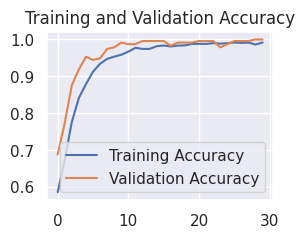

In [ ]:
plt.subplot(2, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

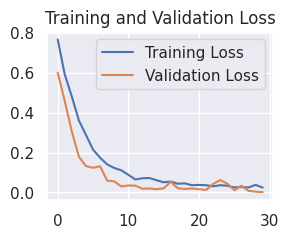

In [ ]:
plt.subplot(2, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.preprocessing import image
color=['#ff6600','#1976D2']

In [ ]:
path='/content/gdrive/MyDrive/Thesis/test/Normal'
l_Normal =[]

In [ ]:
filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Normal =[1]*len(filelist)
print ("Number of images for Normal :" , len (filelist))


Number of images for Normal : 930


In [ ]:
filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Normal =[0]*len(filelist)
print ("Number of images for Normal :" , len (filelist))


Number of images for Normal : 930


In [ ]:
for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Normal.append(test_image)

In [ ]:
l_Normal_result = []

In [ ]:
for i in range(len(l_Normal)):
    # Assuming x is your Sequential model
    predictions = x1.predict(l_Normal[i])

    # Extract the predicted classes (assuming one-hot encoded)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    l_Normal_result.append(predicted_classes)


1/1 [==============================] - 0s 20ms/step


In [ ]:
l_Normal_draw=[]
for i in range(len(l_Normal_result)):
    if (l_Normal_result[i][0] == 0):
        l_Normal_draw.append("Normal")
    else :
        l_Normal_draw.append("Tumor")

In [ ]:
display('==='*10)
display(dict(zip(list(l_Normal_draw),[list(l_Normal_draw).count(i) for i in list(l_Normal_draw)])))
display('==='*10)

'=============================='

{'Normal': 923, 'Tumor': 7}

'=============================='

In [ ]:
res = dict(zip(list(l_Normal_draw),[list(l_Normal_draw).count(i) for i in list(l_Normal_draw)]))
print(res)
labels = ['Normal','Tumor']

{'Normal': 923, 'Tumor': 7}


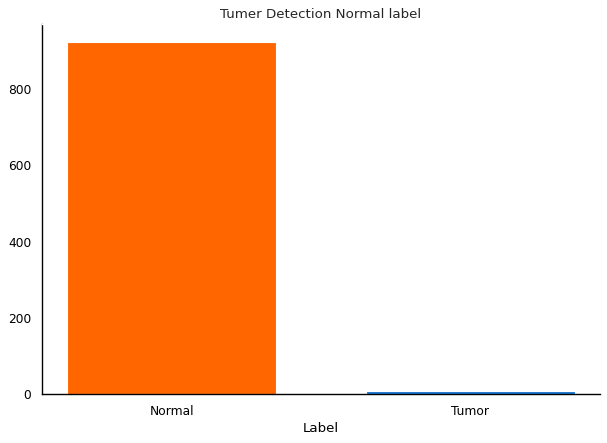

In [ ]:
fig, ax = plt.subplots(figsize = (9 , 6) , dpi=80,)
ax.set_facecolor('#ffffff')
ax.xaxis.label.set_color('#000000')
ax.yaxis.label.set_color('#000000')
ax.tick_params(axis='x', colors='#000000' )
ax.tick_params(axis='y', colors='#000000')
ax.spines['left'].set_color('#000000')        # setting up Y-axis tick color to red
ax.spines['bottom'].set_color('#000000')
plt.bar( labels , res.values() ,width = 0.7,  color=[ '#ff6600', '#1976D2'] ,  align='center' , zorder=1)
plt.xlabel('Label')
plt.title('Tumer Detection Normal label')
plt.show()

In [ ]:
print(res)
print(set(res.values()))

{'Normal': 923, 'Tumor': 7}
{923, 7}


In [ ]:
path='/content/gdrive/MyDrive/Thesis/test/Tumor'
l_Tumor=[]

In [ ]:
filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Tumor =[1]*len(filelist)
print ("Number of images for Tumor :" , len (filelist))

Number of images for Tumor : 1167


In [ ]:
for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Tumor.append(test_image)

In [ ]:
l_Tumor_result=[]

In [ ]:
for i in range(len(l_Tumor)):
    # Assuming x is your Sequential model
    predictions = x1.predict(l_Tumor[i])

    # Extract the predicted classes (assuming one-hot encoded)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    l_Tumor_result.append(predicted_classes)

1/1 [==============================] - 0s 18ms/step


In [ ]:
l_Tumor_draw=[]
for i in range(len(l_Tumor_result)):
    if (l_Tumor_result[i][0]== 0):
        l_Tumor_draw.append("Normal")
    else :
        l_Tumor_draw.append("Tumor")

In [ ]:
display('==='*10)
display(dict(zip(list(l_Tumor_draw),[list(l_Tumor_draw).count(i) for i in list(l_Tumor_draw)])))
display('==='*10)

'=============================='

{'Tumor': 1162, 'Normal': 5}

'=============================='

In [ ]:
res2 = dict(zip(list(l_Tumor_draw),[list(l_Tumor_draw).count(i) for i in list(l_Tumor_draw)]))
print(res2)
labels = ['Normal','Tumor']

{'Tumor': 1162, 'Normal': 5}


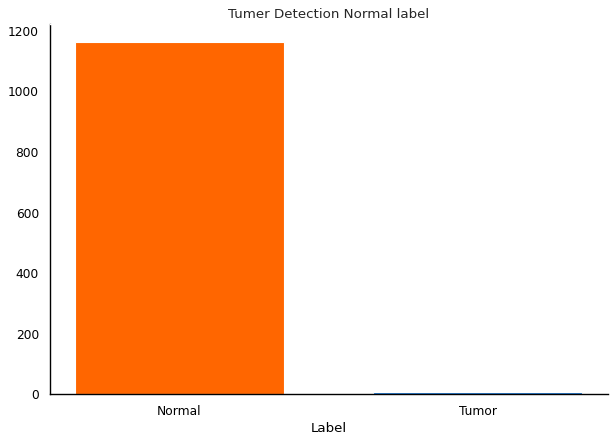

In [ ]:
fig, ax = plt.subplots(figsize = (9 , 6) , dpi=80,)
ax.set_facecolor('#ffffff')
ax.xaxis.label.set_color('#000000')
ax.yaxis.label.set_color('#000000')
ax.tick_params(axis='x', colors='#000000' )
ax.tick_params(axis='y', colors='#000000')
ax.spines['left'].set_color('#000000')        # setting up Y-axis tick color to red
ax.spines['bottom'].set_color('#000000')
plt.bar( labels , res2.values() ,width = 0.7,  color=[ '#ff6600', '#1976D2'] ,  align='center' , zorder=1)
plt.xlabel('Label')
plt.title('Tumer Detection Normal label')
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


In [ ]:
print('Training Set Clases')
print(training_set.class_indices)
print('Testing Set Clases')
print(test_set.class_indices)
print("======"*10)
print('\nConfusion Matrix')
print('Classification Report')
target_names = ['Normal', 'Tumor']

Training Set Clases
{'Normal': 0, 'Tumor': 1}
Testing Set Clases
{'Normal': 0, 'Tumor': 1}

Confusion Matrix
Classification Report


In [ ]:
y_labels  = y_Normal +y_Tumor
x_results = l_Normal_result + l_Tumor_result
print(classification_report( y_labels , x_results , target_names=target_names))


              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       930
       Tumor       0.99      1.00      0.99      1167

    accuracy                           0.99      2097
   macro avg       0.99      0.99      0.99      2097
weighted avg       0.99      0.99      0.99      2097



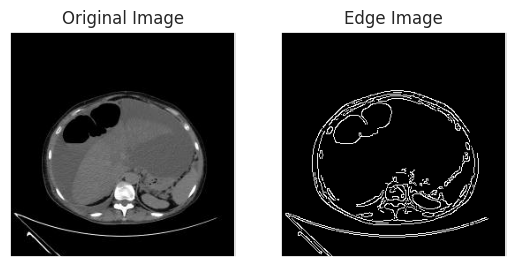

In [ ]:
path='/content/gdrive/MyDrive/Thesis/validation/Normal/124.jpeg'
path2='/content/gdrive/MyDrive/Thesis/validation/Tumor/110.jpeg'
img=cv2.imread(path)
edges = cv2.Canny(img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

# VGG16

In [ ]:
datagen = ImageDataGenerator(rescale=1/255,
                             rotation_range=20,
                             horizontal_flip=True,
                             height_shift_range=0.1,
                             width_shift_range=0.1,
                             shear_range=0.1,
                             brightness_range=[0.3, 1.5],
                             validation_split=0.2
                            )

In [ ]:
train_gen= datagen.flow_from_directory('/content/gdrive/MyDrive/Thesis/train',
                                       target_size=(224,224),
                                       class_mode='sparse',
                                       #subset='training'
                                      )

Found 5439 images belonging to 2 classes.


In [ ]:
val_gen = datagen.flow_from_directory( '/content/gdrive/MyDrive/Thesis/validation',
                                       target_size=(224,224),
                                       class_mode='sparse',
                                      #subset='validation'
                                      )

Found 234 images belonging to 2 classes.


In [ ]:
vgg_model=VGG16(weights='imagenet',input_shape=(224,224,3),include_top=False)
model=keras.Sequential()
for layer in vgg_model.layers:
    model.add(layer)
for layer in model.layers:
    layer.trainable=False


58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

In [ ]:
stop = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10
)

In [ ]:
checkpoint= ModelCheckpoint(
    filepath='./',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history=model.fit(train_gen,validation_data=val_gen,epochs=30,callbacks=[stop,checkpoint])

Epoch 1/30
170/170 [==============================] - 3978s 23s/step - loss: 0.7856 - accuracy: 0.6220 - val_loss: 0.5228 - val_accuracy: 0.7521
Epoch 2/30
170/170 [==============================] - 76s 447ms/step - loss: 0.5522 - accuracy: 0.7261 - val_loss: 0.5122 - val_accuracy: 0.7393
Epoch 3/30
170/170 [==============================] - 75s 443ms/step - loss: 0.5052 - accuracy: 0.7525 - val_loss: 0.4421 - val_accuracy: 0.7949
Epoch 4/30
170/170 [==============================] - 77s 450ms/step - loss: 0.4695 - accuracy: 0.7764 - val_loss: 0.4099 - val_accuracy: 0.8376
Epoch 5/30
170/170 [==============================] - 77s 448ms/step - loss: 0.4271 - accuracy: 0.7932 - val_loss: 0.3785 - val_accuracy: 0.8590
Epoch 6/30
170/170 [==============================] - 76s 446ms/step - loss: 0.4118 - accuracy: 0.8051 - val_loss: 0.3846 - val_accuracy: 0.8333
Epoch 7/30
170/170 [==============================] - 76s 447ms/step - loss: 0.3836 - accuracy: 0.8226 - val_loss: 0.3655 - val_ac

In [ ]:
print('Training Set Clases : ', training_set.class_indices )
print("=="*10)
print('Testing Set Clases : ' , test_set.class_indices )

Training Set Clases :  {'Normal': 0, 'Tumor': 1}
Testing Set Clases :  {'Normal': 0, 'Tumor': 1}


In [ ]:
loss,accuracy=model.evaluate(test_set)
print (f"Test Loss     = {loss}")
print (f"Test Accuracy = {accuracy}")

66/66 [==============================] - 1394s 21s/step - loss: 27.5292 - accuracy: 0.6834
Test Loss     = 27.529172897338867
Test Accuracy = 0.6833571791648865


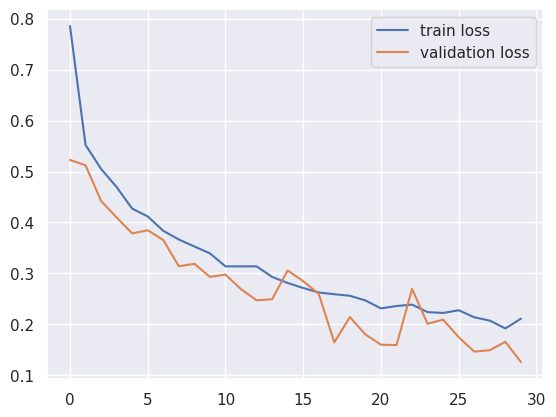

In [ ]:
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.legend()

In [ ]:
from keras.preprocessing import image

path='/content/gdrive/MyDrive/Thesis/test/Normal'
l_Normal =[]


In [ ]:
filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Normal =[0]*len(filelist)
print ("Number of images for Normal :" , len (filelist))


Number of images for Normal : 930


In [ ]:
for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Normal.append(test_image)

In [ ]:
l_Normal_result = []

In [ ]:
for i in range(len(l_Normal)):
    # Assuming x is your Sequential model
    predictions = model.predict(l_Normal[i])

    # Extract the predicted classes (assuming one-hot encoded)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    l_Normal_result.append(predicted_classes)

1/1 [==============================] - 0s 19ms/step


In [ ]:
l_Normal_draw=[]
for i in range(len(l_Normal_result)):
    if (l_Normal_result[i][0] == 0):
        l_Normal_draw.append("Normal")
    else :
        l_Normal_draw.append("Tumor")

In [ ]:
display('==='*10)
display(dict(zip(list(l_Normal_draw),[list(l_Normal_draw).count(i) for i in list(l_Normal_draw)])))
display('==='*10)

'=============================='

{'Normal': 930}

'=============================='

In [ ]:
res = dict(zip(list(l_Normal_draw),[list(l_Normal_draw).count(i) for i in list(l_Normal_draw)]))
print(res)
labels = ['Normal','Tumor']

{'Normal': 930}


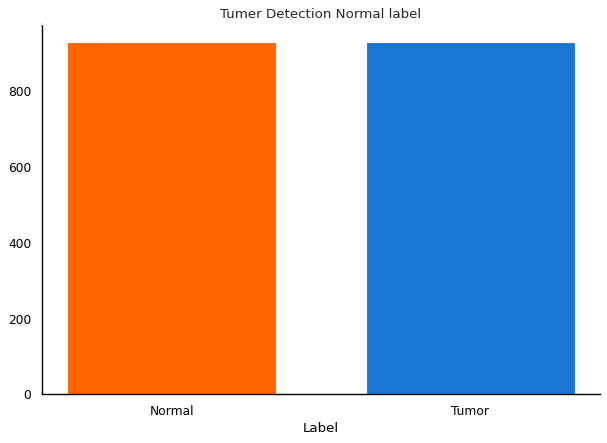

In [ ]:
fig, ax = plt.subplots(figsize = (9 , 6) , dpi=80,)
ax.set_facecolor('#ffffff')
ax.xaxis.label.set_color('#000000')
ax.yaxis.label.set_color('#000000')
ax.tick_params(axis='x', colors='#000000' )
ax.tick_params(axis='y', colors='#000000')
ax.spines['left'].set_color('#000000')        # setting up Y-axis tick color to red
ax.spines['bottom'].set_color('#000000')
plt.bar( labels , res.values() ,width = 0.7,  color=[ '#ff6600', '#1976D2'] ,  align='center' , zorder=1)
plt.xlabel('Label')
plt.title('Tumer Detection Normal label')
plt.show()

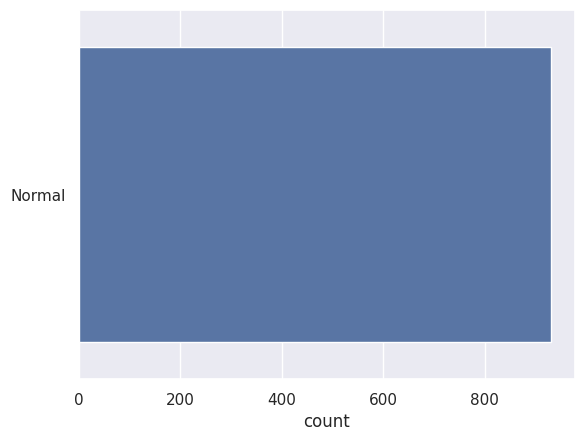

In [ ]:
sns.set_style('darkgrid')
sns.countplot(l_Normal_draw)
plt.show()

In [ ]:
from keras.preprocessing import image

path='/content/gdrive/MyDrive/Thesis/test/Tumor'
l_Tumor=[]

In [ ]:
filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Tumor =[1]*len(filelist)
print ("Number of images for Tumor :" , len (filelist))

Number of images for Tumor : 1167


In [ ]:
for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Tumor.append(test_image)

In [ ]:
l_Tumor_result=[]

In [ ]:
for i in range(len(l_Tumor)):
    # Assuming x is your Sequential model
    predictions = model.predict(l_Tumor[i])

    # Extract the predicted classes (assuming one-hot encoded)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    l_Tumor_result.append(predicted_classes)


1/1 [==============================] - 0s 17ms/step


In [ ]:
l_Tumor_draw=[]
for i in range(len(l_Tumor_result)):
    if (l_Tumor_result[i][0]== 0):
        l_Tumor_draw.append("Normal")
    else :
        l_Tumor_draw.append("Tumor")

In [ ]:
display('==='*10)
display(dict(zip(list(l_Tumor_draw),[list(l_Tumor_draw).count(i) for i in list(l_Tumor_draw)])))
display('==='*10)

'=============================='

{'Normal': 1167}

'=============================='

In [ ]:
res2 = dict(zip(list(l_Tumor_draw),[list(l_Tumor_draw).count(i) for i in list(l_Tumor_draw)]))
print(res2)
labels = ['Normal','Tumor']

{'Normal': 1167}


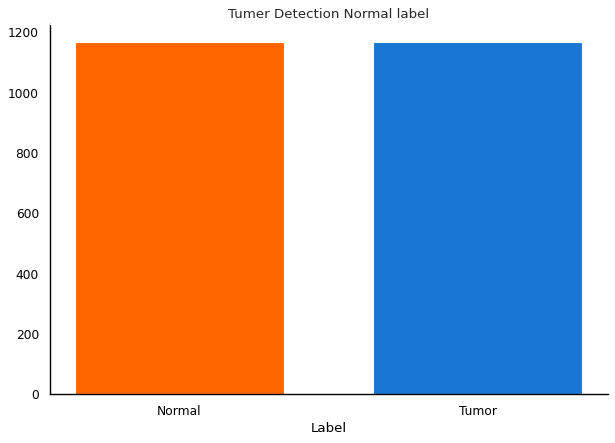

In [ ]:
fig, ax = plt.subplots(figsize = (9 , 6) , dpi=80,)
ax.set_facecolor('#ffffff')
ax.xaxis.label.set_color('#000000')
ax.yaxis.label.set_color('#000000')
ax.tick_params(axis='x', colors='#000000' )
ax.tick_params(axis='y', colors='#000000')
ax.spines['left'].set_color('#000000')        # setting up Y-axis tick color to red
ax.spines['bottom'].set_color('#000000')
plt.bar( labels , res2.values() ,width = 0.7,  color=[ '#ff6600', '#1976D2'] ,  align='center' , zorder=1)
plt.xlabel('Label')
plt.title('Tumer Detection Normal label')
plt.show()

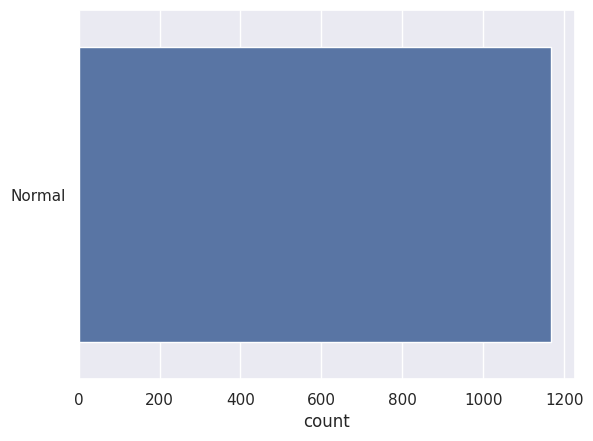

In [ ]:
sns.set_style('darkgrid')
sns.countplot(l_Tumor_draw)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [ ]:

print('Training Set Clases')
print(training_set.class_indices)
print('Testing Set Clases')
print(test_set.class_indices)
print("======"*10)
print('\nConfusion Matrix')
print('Classification Report')
target_names = ['Normal', 'Tumor']

Training Set Clases
{'Normal': 0, 'Tumor': 1}
Testing Set Clases
{'Normal': 0, 'Tumor': 1}

Confusion Matrix
Classification Report


In [ ]:
y_labels  = y_Normal +y_Tumor
x_results = l_Normal_result + l_Tumor_result
print(classification_report( y_labels , x_results , target_names=target_names))


              precision    recall  f1-score   support

      Normal       0.44      1.00      0.61       930
       Tumor       0.00      0.00      0.00      1167

    accuracy                           0.44      2097
   macro avg       0.22      0.50      0.31      2097
weighted avg       0.20      0.44      0.27      2097



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ResNet50

In [ ]:
stop = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10
)

In [ ]:
base_model_2 = Sequential()
base_model_2.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model_2.add(Dropout(0.25))
base_model_2.add(Flatten())
base_model_2.add(Dense(units = 128, activation = 'relu'))
base_model_2.add(Dense(2, activation='softmax'))

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
base_model_2.compile(
    optimizer='adam' ,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']    )


In [ ]:
base_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 23850242 (90.98 MB)
Trainable params: 23797122 (90.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
history=base_model_2.fit(training_set,validation_data=validation_set,epochs=30,callbacks=[stop])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 [==============================] - 3699s 22s/step - loss: 1.2202 - accuracy: 0.5552 - val_loss: 0.9572 - val_accuracy: 0.5726
Epoch 2/30
170/170 [==============================] - 66s 387ms/step - loss: 0.5511 - accuracy: 0.7316 - val_loss: 0.5440 - val_accuracy: 0.7179
Epoch 3/30
170/170 [==============================] - 67s 389ms/step - loss: 0.3694 - accuracy: 0.8375 - val_loss: 0.8710 - val_accuracy: 0.6880
Epoch 4/30
170/170 [==============================] - 65s 383ms/step - loss: 0.2654 - accuracy: 0.8910 - val_loss: 2.0687 - val_accuracy: 0.6197
Epoch 5/30
170/170 [==============================] - 66s 386ms/step - loss: 0.2176 - accuracy: 0.9154 - val_loss: 0.6726 - val_accuracy: 0.8120
Epoch 6/30
170/170 [==============================] - 66s 386ms/step - loss: 0.1863 - accuracy: 0.9283 - val_loss: 0.6215 - val_accuracy: 0.7863
Epoch 7/30
170/170 [==============================] - 66s 384ms/step - loss: 0.1438 - accuracy: 0.9436 - val_loss: 0.3308 - val_accuracy: 0.8

In [ ]:
print('Training Set Clases : ', training_set.class_indices )
print("=="*10)
print('Testing Set Clases : ' , test_set.class_indices )


Training Set Clases :  {'Normal': 0, 'Tumor': 1}
Testing Set Clases :  {'Normal': 0, 'Tumor': 1}


In [ ]:
loss,accuracy=base_model_2.evaluate(test_set)
print (f"Test Loss     = {loss}")
print (f"Test Accuracy = {accuracy}")

66/66 [==============================] - 1329s 20s/step - loss: 0.2621 - accuracy: 0.9185
Test Loss     = 0.26214322447776794
Test Accuracy = 0.9184549450874329


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

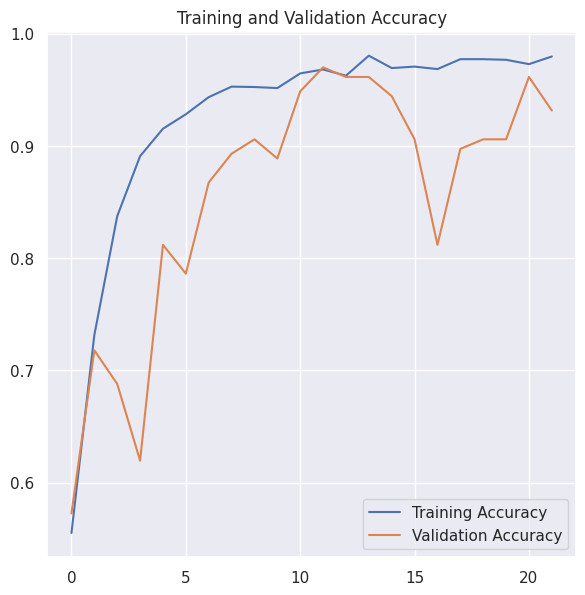

In [ ]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

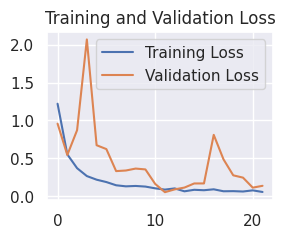

In [ ]:
plt.subplot(2, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.preprocessing import image

path='/content/gdrive/MyDrive/Thesis/test/Normal'
l_Normal =[]

In [ ]:
filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Normal =[0]*len(filelist)
print ("Number of images for Normal :" , len (filelist))


Number of images for Normal : 930


In [ ]:
for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Normal.append(test_image)

In [ ]:
l_Normal_result = []

In [ ]:
for i in range(len(l_Normal)):
    # Assuming x is your Sequential model
    predictions = base_model_2.predict(l_Normal[i])

    # Extract the predicted classes (assuming one-hot encoded)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    l_Normal_result.append(predicted_classes)

1/1 [==============================] - 0s 21ms/step


In [ ]:
l_Normal_draw=[]
for i in range(len(l_Normal_result)):
    if (l_Normal_result[i][0] == 0):
        l_Normal_draw.append("Normal")
    else :
        l_Normal_draw.append("Tumor")

In [ ]:
display('==='*10)
display(dict(zip(list(l_Normal_draw),[list(l_Normal_draw).count(i) for i in list(l_Normal_draw)])))
display('==='*10)

'=============================='

{'Normal': 775, 'Tumor': 155}

'=============================='

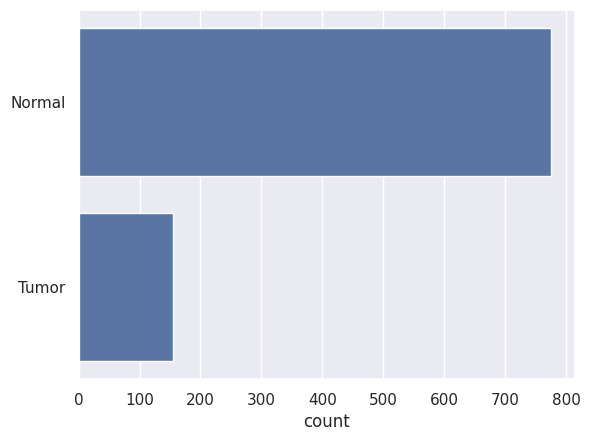

In [ ]:
sns.set_style('darkgrid')
sns.countplot(l_Normal_draw)
plt.show()

In [ ]:
from keras.preprocessing import image

path='/content/gdrive/MyDrive/Thesis/test/Tumor'
l_Tumor=[]

In [ ]:
filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Tumor =[1]*len(filelist)
print ("Number of images for Tumor :" , len (filelist))

Number of images for Tumor : 1167


In [ ]:
for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Tumor.append(test_image)

In [ ]:
l_Tumor_result=[]

In [ ]:
for i in range(len(l_Tumor)):
    # Assuming x is your Sequential model
    predictions = base_model_2.predict(l_Tumor[i])

    # Extract the predicted classes (assuming one-hot encoded)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    l_Tumor_result.append(predicted_classes)


1/1 [==============================] - 0s 22ms/step


In [ ]:
l_Tumor_draw=[]
for i in range(len(l_Tumor_result)):
    if (l_Tumor_result[i][0]== 0):
        l_Tumor_draw.append("Normal")
    else :
        l_Tumor_draw.append("Tumor")

In [ ]:
display('==='*10)
display(dict(zip(list(l_Tumor_draw),[list(l_Tumor_draw).count(i) for i in list(l_Tumor_draw)])))
display('==='*10)


'=============================='

{'Tumor': 1151, 'Normal': 16}

'=============================='

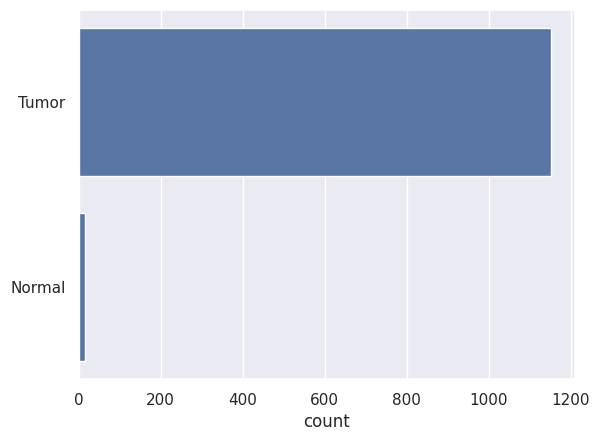

In [ ]:
sns.set_style('darkgrid')
sns.countplot(l_Tumor_draw)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [ ]:
print('Training Set Clases')
print(training_set.class_indices)
print('Testing Set Clases')
print(test_set.class_indices)
print("======"*10)
print('\nConfusion Matrix')
print('Classification Report')
target_names = ['Normal', 'Tumor']


Training Set Clases
{'Normal': 0, 'Tumor': 1}
Testing Set Clases
{'Normal': 0, 'Tumor': 1}

Confusion Matrix
Classification Report


In [ ]:
y_labels  = y_Normal +y_Tumor
x_results = l_Normal_result + l_Tumor_result
print(classification_report( y_labels , x_results , target_names=target_names))


              precision    recall  f1-score   support

      Normal       0.98      0.83      0.90       930
       Tumor       0.88      0.99      0.93      1167

    accuracy                           0.92      2097
   macro avg       0.93      0.91      0.92      2097
weighted avg       0.92      0.92      0.92      2097



# InceptionV3

In [16]:
stop = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10
)

In [17]:
base_model_3 = Sequential()
base_model_3.add(InceptionV3(weights='imagenet',input_shape=(224,224,3), include_top=False))
base_model_3.add(Dropout(0.25))
base_model_3.add(Flatten())
base_model_3.add(Dense(units = 128, activation = 'relu'))
base_model_3.add(Dense(2, activation='softmax'))

87910968/87910968 [==============================] - 5s 0us/step


In [18]:
base_model_3.compile(
    optimizer='adam' ,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']    )

In [19]:
base_model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 5, 5, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 128)               6553728   
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 28356770 (108.17 MB)
Trainable params: 28322338 (108.04 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________


In [20]:
history=base_model_3.fit(training_set,validation_data=validation_set,epochs=30,callbacks=[stop])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 [==============================] - 4351s 25s/step - loss: 0.8485 - accuracy: 0.6225 - val_loss: 0.4732 - val_accuracy: 0.7650
Epoch 2/30
170/170 [==============================] - 70s 410ms/step - loss: 0.3908 - accuracy: 0.8391 - val_loss: 0.2201 - val_accuracy: 0.9060
Epoch 3/30
170/170 [==============================] - 69s 407ms/step - loss: 0.3324 - accuracy: 0.8628 - val_loss: 1.5073 - val_accuracy: 0.6966
Epoch 4/30
170/170 [==============================] - 71s 414ms/step - loss: 0.2287 - accuracy: 0.9097 - val_loss: 0.2121 - val_accuracy: 0.9145
Epoch 5/30
170/170 [==============================] - 70s 411ms/step - loss: 0.3171 - accuracy: 0.8730 - val_loss: 0.6874 - val_accuracy: 0.5598
Epoch 6/30
170/170 [==============================] - 70s 411ms/step - loss: 0.2371 - accuracy: 0.9040 - val_loss: 0.4821 - val_accuracy: 0.7949
Epoch 7/30
170/170 [==============================] - 69s 406ms/step - loss: 0.1542 - accuracy: 0.9419 - val_loss: 0.3862 - val_accuracy: 0.8

In [21]:
print('Training Set Clases : ', training_set.class_indices )
print("=="*10)
print('Testing Set Clases : ' , test_set.class_indices )

Training Set Clases :  {'Normal': 0, 'Tumor': 1}
Testing Set Clases :  {'Normal': 0, 'Tumor': 1}


In [22]:
loss,accuracy=base_model_3.evaluate(test_set)
print (f"Test Loss     = {loss}")
print (f"Test Accuracy = {accuracy}")

66/66 [==============================] - 1569s 24s/step - loss: 1.6781 - accuracy: 0.8603
Test Loss     = 1.6781318187713623
Test Accuracy = 0.8602765798568726


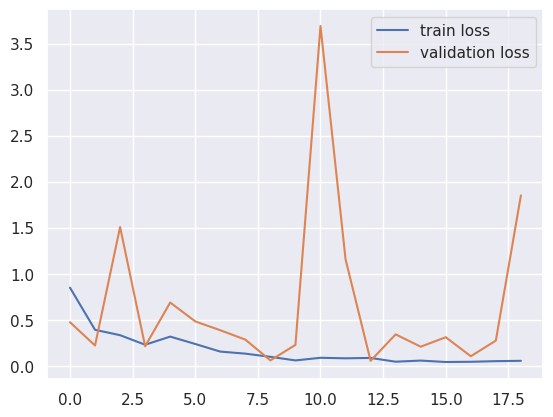

In [23]:
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.legend()

In [24]:
from keras.preprocessing import image

path='/content/gdrive/MyDrive/Thesis/test/Normal'
l_Normal =[]


In [25]:
filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Normal =[0]*len(filelist)
print ("Number of images for Normal :" , len (filelist))

Number of images for Normal : 930


In [26]:
for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Normal.append(test_image)


In [29]:
l_Normal_result=[]
for i in range(len(l_Normal)):
    # Assuming x is your Sequential model
    predictions = base_model_3.predict(l_Normal[i])

    # Extract the predicted classes (assuming one-hot encoded)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    l_Normal_result.append(predicted_classes)

1/1 [==============================] - 0s 25ms/step


In [30]:
l_Normal_draw=[]
for i in range(len(l_Normal_result)):
    if (l_Normal_result[i][0] == 0):
        l_Normal_draw.append("Normal")
    else :
        l_Normal_draw.append("Tumor")

In [31]:

display('==='*10)
display(dict(zip(list(l_Normal_draw),[list(l_Normal_draw).count(i) for i in list(l_Normal_draw)])))
display('==='*10)


'=============================='

{'Tumor': 283, 'Normal': 647}

'=============================='

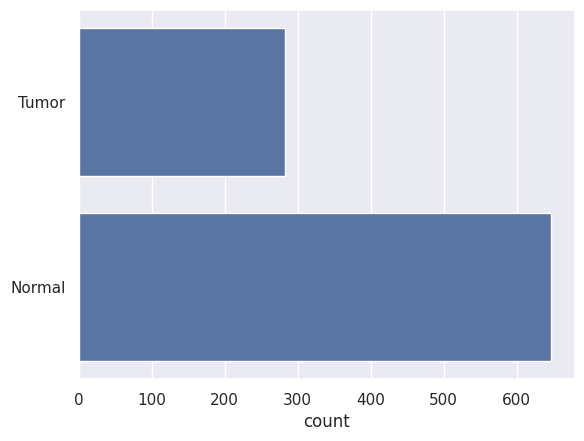

In [32]:
sns.set_style('darkgrid')
sns.countplot(l_Normal_draw)
plt.show()


In [33]:
from keras.preprocessing import image

path='/content/gdrive/MyDrive/Thesis/test/Tumor'
l_Tumor=[]

In [34]:
filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Tumor =[1]*len(filelist)
print ("Number of images for Tumor :" , len (filelist))

Number of images for Tumor : 1167


In [35]:
for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Tumor.append(test_image)

In [36]:
l_Tumor_result=[]

for i in range(len(l_Tumor)):
    # Assuming x is your Sequential model
    predictions = base_model_3.predict(l_Tumor[i])

    # Extract the predicted classes (assuming one-hot encoded)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    l_Tumor_result.append(predicted_classes)

1/1 [==============================] - 0s 26ms/step


In [37]:
l_Tumor_draw=[]
for i in range(len(l_Tumor_result)):
    if (l_Tumor_result[i][0]== 0):
        l_Tumor_draw.append("Normal")
    else :
        l_Tumor_draw.append("Tumor")

In [38]:

display('==='*10)
display(dict(zip(list(l_Tumor_draw),[list(l_Tumor_draw).count(i) for i in list(l_Tumor_draw)])))
display('==='*10)

'=============================='

{'Tumor': 1157, 'Normal': 10}

'=============================='

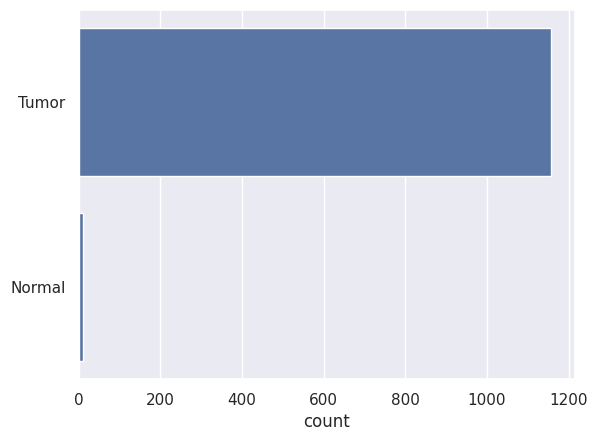

In [39]:
sns.set_style('darkgrid')
sns.countplot(l_Tumor_draw)
plt.show()

In [40]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [41]:
print('Training Set Clases')
print(training_set.class_indices)
print('Testing Set Clases')
print(test_set.class_indices)
print("======"*10)
print('\nConfusion Matrix')
print('Classification Report')
target_names = ['Normal', 'Tumor']

Training Set Clases
{'Normal': 0, 'Tumor': 1}
Testing Set Clases
{'Normal': 0, 'Tumor': 1}

Confusion Matrix
Classification Report


In [44]:
y_labels  = y_Normal +y_Tumor
x_results = l_Normal_result + l_Tumor_result
print(classification_report( y_labels , x_results , target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.98      0.70      0.82       930
       Tumor       0.80      0.99      0.89      1167

    accuracy                           0.86      2097
   macro avg       0.89      0.84      0.85      2097
weighted avg       0.88      0.86      0.86      2097





# Xception



In [45]:
stop = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10
)

In [46]:
# Create a Sequential model
base_model_3 = Sequential()

# Add Xception as a layer
xception_layer = Xception(weights='imagenet', include_top=False, pooling='max')
base_model_3.add(xception_layer)

# Add dropout layer
base_model_3.add(Dropout(0.25))

# Flatten the output
base_model_3.add(Flatten())

# Add dense layers
base_model_3.add(Dense(units=128, activation='relu'))
base_model_3.add(Dense(units=2, activation='softmax'))

# Display model summary
#base_model_2.summary()

83683744/83683744 [==============================] - 6s 0us/step


In [47]:
base_model_3.compile(
    optimizer='adam' ,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']    )

In [48]:
base_model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 21124010 (80.58 MB)
Trainable params: 21069482 (80.37 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [49]:
history=base_model_3.fit(training_set,validation_data=validation_set,epochs=30,callbacks=[stop])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 [==============================] - 126s 560ms/step - loss: 0.5429 - accuracy: 0.7303 - val_loss: 0.9726 - val_accuracy: 0.6453
Epoch 2/30
170/170 [==============================] - 85s 498ms/step - loss: 0.3127 - accuracy: 0.8735 - val_loss: 2.2645 - val_accuracy: 0.7821
Epoch 3/30
170/170 [==============================] - 85s 499ms/step - loss: 0.1619 - accuracy: 0.9386 - val_loss: 0.2633 - val_accuracy: 0.8718
Epoch 4/30
170/170 [==============================] - 85s 498ms/step - loss: 0.1045 - accuracy: 0.9616 - val_loss: 0.4611 - val_accuracy: 0.8761
Epoch 5/30
170/170 [==============================] - 85s 499ms/step - loss: 0.0941 - accuracy: 0.9665 - val_loss: 0.2795 - val_accuracy: 0.9103
Epoch 6/30
170/170 [==============================] - 85s 500ms/step - loss: 0.0797 - accuracy: 0.9744 - val_loss: 2.3917 - val_accuracy: 0.6453
Epoch 7/30
170/170 [==============================] - 85s 500ms/step - loss: 0.0556 - accuracy: 0.9803 - val_loss: 0.2370 - val_accuracy: 0.

In [50]:
print('Training Set Clases : ', training_set.class_indices )
print("=="*10)
print('Testing Set Clases : ' , test_set.class_indices )


Training Set Clases :  {'Normal': 0, 'Tumor': 1}
Testing Set Clases :  {'Normal': 0, 'Tumor': 1}


In [52]:
loss,accuracy=base_model_3.evaluate(test_set)
print (f"Test Loss     = {loss}")
print (f"Test Accuracy = {accuracy}")

66/66 [==============================] - 11s 169ms/step - loss: 0.1148 - accuracy: 0.9552
Test Loss     = 0.1148141622543335
Test Accuracy = 0.9551740288734436


In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


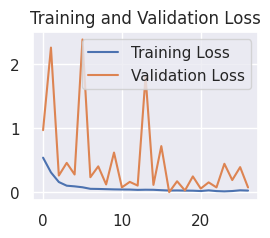

In [54]:
plt.subplot(2, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [55]:
from keras.preprocessing import image

path='/content/gdrive/MyDrive/Thesis/test/Normal'
l_Normal =[]

In [56]:
filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Normal =[0]*len(filelist)
print ("Number of images for Normal :" , len (filelist))

Number of images for Normal : 930


In [57]:
for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Normal.append(test_image)

In [60]:
l_Normal_result=[]
for i in range(len(l_Normal)):
    # Assuming x is your Sequential model
    predictions = base_model_3.predict(l_Normal[i])

    # Extract the predicted classes (assuming one-hot encoded)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    l_Normal_result.append(predicted_classes)

1/1 [==============================] - 0s 27ms/step


In [61]:
l_Normal_draw=[]
for i in range(len(l_Normal_result)):
    if (l_Normal_result[i][0] == 0):
        l_Normal_draw.append("Normal")
    else :
        l_Normal_draw.append("Tumor")


In [62]:
display('==='*10)
display(dict(zip(list(l_Normal_draw),[list(l_Normal_draw).count(i) for i in list(l_Normal_draw)])))
display('==='*10)


'=============================='

{'Normal': 913, 'Tumor': 17}

'=============================='

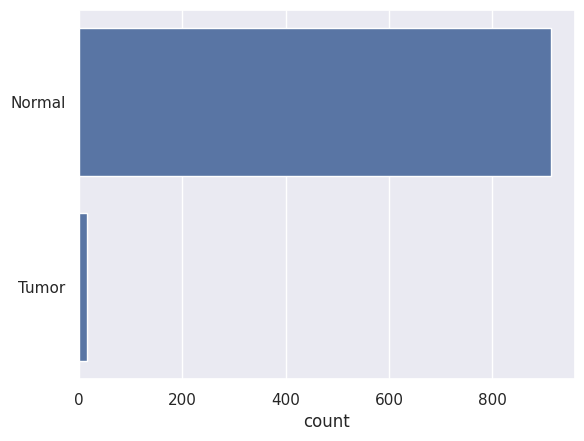

In [63]:
sns.set_style('darkgrid')
sns.countplot(l_Normal_draw)
plt.show()

In [64]:
from keras.preprocessing import image

path='/content/gdrive/MyDrive/Thesis/test/Tumor'
l_Tumor=[]

In [65]:
filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Tumor =[1]*len(filelist)
print ("Number of images for Tumor :" , len (filelist))

Number of images for Tumor : 1167


In [66]:
for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Tumor.append(test_image)

In [67]:
l_Tumor_result=[]

for i in range(len(l_Tumor)):
    # Assuming x is your Sequential model
    predictions = base_model_3.predict(l_Tumor[i])

    # Extract the predicted classes (assuming one-hot encoded)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    l_Tumor_result.append(predicted_classes)

1/1 [==============================] - 0s 22ms/step


In [68]:
l_Tumor_draw=[]
for i in range(len(l_Tumor_result)):
    if (l_Tumor_result[i][0]== 0):
        l_Tumor_draw.append("Normal")
    else :
        l_Tumor_draw.append("Tumor")


In [69]:
display('==='*10)
display(dict(zip(list(l_Tumor_draw),[list(l_Tumor_draw).count(i) for i in list(l_Tumor_draw)])))
display('==='*10)

'=============================='

{'Tumor': 1090, 'Normal': 77}

'=============================='

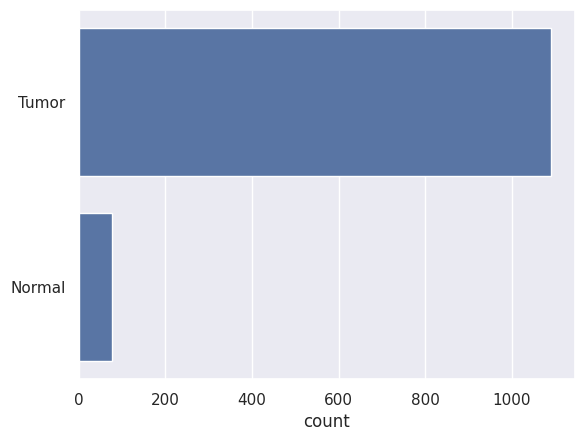

In [70]:
sns.set_style('darkgrid')
sns.countplot(l_Tumor_draw)
plt.show()

In [71]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

print('Training Set Clases')
print(training_set.class_indices)
print('Testing Set Clases')
print(test_set.class_indices)
print("======"*10)
print('\nConfusion Matrix')
print('Classification Report')
target_names = ['Normal', 'Tumor']

Training Set Clases
{'Normal': 0, 'Tumor': 1}
Testing Set Clases
{'Normal': 0, 'Tumor': 1}

Confusion Matrix
Classification Report


In [72]:
y_labels  = y_Normal +y_Tumor
x_results = l_Normal_result + l_Tumor_result
print(classification_report( y_labels , x_results , target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.92      0.98      0.95       930
       Tumor       0.98      0.93      0.96      1167

    accuracy                           0.96      2097
   macro avg       0.95      0.96      0.95      2097
weighted avg       0.96      0.96      0.96      2097

